In [1]:
#%matplotlib notebook
from scipy.spatial import cKDTree
import pyfits, mechanize, bz2, os
from matplotlib import pyplot as pl
from numpy import *
from scipy.optimize import leastsq
import astropy.stats as sta
from scipy import ndimage
from glob import glob
import pandas as pd  #為了讀csv檔。csv檔是以逗點分割的檔案。
import requests
from bs4 import BeautifulSoup
from astropy.io import ascii
import concurrent.futures
from time import sleep
from astropy.table import Table
import math as m
import gzip
import patoolib
import glob
import collections

In [3]:
os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4\ktwo201164732_C1')

In [4]:
glob.glob('*fits')

['spec-57401-HD112914S042705B01_sp08-067.fits']

In [5]:
ptf1 = pyfits.open('spec-57401-HD112914S042705B01_sp08-067.fits')

In [8]:
ptf1[0].header

SIMPLE  =                    T /Primary Header created by MWRFITS v1.11b        
BITPIX  =                  -32 /                                                
NAXIS   =                    2 / Number of array dimensions                     
NAXIS1  =                 3909 /                                                
NAXIS2  =                    5 /                                                
EXTEND  =                    T /                                                
                                                                                
COMMENT --------FILE INFORMATION                                                
FILENAME= 'spec-57401-HD112914S042705B01_sp08-067.fits' /                       
OBSID   =            407008067 / Unique number ID of this spectrum              
AUTHOR  = 'LAMOST Pipeline'    / Who compiled the information                   
DATA_V  = 'LAMOST DR4'         / Data release version                           
EXTEN0  = 'Flux, Inverse, Wa

In [7]:
tbdata = ptf1[0].data

In [17]:
len(tbdata[2])

NameError: name 'tbdata' is not defined

In [72]:
tbdata[0]

array([ 27.2674408 ,  66.51286316, -53.22683716, ...,   0.        ,
         0.        ,   0.        ], dtype=float32)

In [69]:
tbdata[2]

array([ 3699.98632812,  3700.83837891,  3701.69067383, ...,  9094.9453125 ,
        9097.04003906,  9099.13476562], dtype=float32)

<IPython.core.display.Javascript object>


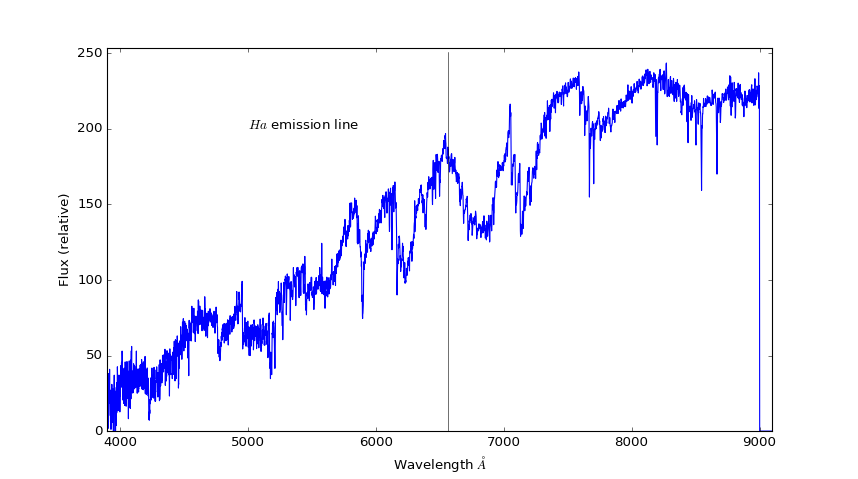

In [66]:
pl.ylim(0, max(tbdata[0])+10)
pl.xlim(3900, max(tbdata[2]))
pl.xlabel('Wavelength $\AA$')
pl.ylabel('Flux (relative)')
pl.plot(tbdata[2], tbdata[0])
pl.text(5000.66, 200, r'$Ha$ emission line')
pl.axvline(x=6564.66, ymin=-0.99, ymax = 0.99, linewidth=0.5 ,color='k')
pl.show()

In [103]:
for i in range(len(tbdata[2])):
    if tbdata[2][i] > 6564 and tbdata[2][i] < 6565:
        print 'wavelength = ',tbdata[2][i],'Angstrom'
        print 'Flux (relative) = ',tbdata[0][i]

wavelength =  6564.48 Angstrom
Flux (relative) =  183.106


In [106]:
for i in range(len(tbdata[2])):
    if tbdata[2][i] > 6632 and tbdata[2][i] < 6633:
        print 'wavelength = ',tbdata[2][i],'Angstrom'
        print 'Flux (relative) = ',tbdata[0][i]

wavelength =  6632.85 Angstrom
Flux (relative) =  166.541


In [54]:
(2.5*log10(183.106/166.541))   
#EPIC 201164732 在 PTF HA subtraction 得到正值(Ha663-Ha656)，應該是有HA emission。然而，lamost得到的HA663-HA656得到的也是正值
#檢查了PTF的資料，發現兩張PTF FITS觀測的時間點不一樣，一個是2012年觀測，另一個是2016年。
#所以，之後將進行PTF 不同時間點觀測的數據進行 seeing normalization，然後再做一次PTF lamost之間 HA subtraction的比對。
#或者，這次我在做lamost ha subtraction時，並沒有將 EW (等效寬度) 考慮進去。 可以想再做一次考慮EW的 lamost ha subtraction，
#並與ptf的結果比對。
#考慮 EW lamost ha subtraction為優先處理事項。

0.10295351847981071

In [111]:
((-2.5*log10(183.106/166.541))/-2.5*log10(166.541))

0.091485368251795401

In [110]:
abs((-2.5*log10(183.106/166.541))/-2.5*log10(166.541))

0.091485368251795401

In [8]:
#20170316

data_ktwo_list =  glob.glob('ktwo*')

In [9]:
len(data_ktwo_list)

386

In [10]:
ha_sub_m_list =[]
filename_list = []

In [11]:
def lamost_hasub(filename):
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4/'+filename)
    fits_list = glob.glob('*fits')
    fits = pyfits.open(fits_list[0])
    tbdata = fits[0].data
    relative_flux = tbdata[0]
    wavelength = tbdata[2]
    ha656f = []
    ha663f = []
    for i in range(len(wavelength)):
        if wavelength[i] > 6564 and wavelength[i] < 6565:
            print 'HA656 wavelength = ',wavelength[i],'Angstrom'
            print 'Flux (relative) = ',relative_flux[i]
            ha656f.append(relative_flux[i])
    for a in range(len(tbdata[2])):
        if wavelength[a] > 6632 and wavelength[a] < 6633:
            print 'HA663 wavelength = ',wavelength[a],'Angstrom'
            print 'Flux (relative) = ',relative_flux[a]
            ha663f.append(relative_flux[a])
    print ha656f[0], ha663f[0]
    ha_sub_m = 2.5*log10(ha656f[0]/ha663f[0])
    ha_sub_f = ha656f[0] - ha663f[0]
    print ha_sub_m, ha_sub_f, filename
    ha_sub_m, ha_sub_f, filename
    ha_sub_m_list.append(ha_sub_m)
    filename_list.append(filename)
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4')

In [12]:
for i in range(len(data_ktwo_list)):
    lamost_hasub(data_ktwo_list[i])

HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  183.106
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  166.541
183.106 166.541
0.102955773473 16.5653 ktwo201164732_C1
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  12.9503
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  12.2065
12.9503 12.2065
0.0642231851816 0.743815 ktwo201165258_C1
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  559.838
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  525.255
559.838 525.255
0.0692305294797 34.583 ktwo201168957_C1
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  94.5433
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  98.6085
94.5433 98.6085
-0.0457095494494 -4.06525 ktwo201176072_C1
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  957.894
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  926.44
957.894 926.44
0.0362505670637 31.4542 ktwo201184549_C1
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  2153.2
HA663 wavelen

In [13]:
ha656fr = []
ha663fr = []

In [14]:
def lamost_ha(filename):
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4/'+filename)
    fits_list = glob.glob('*fits')
    fits = pyfits.open(fits_list[0])
    tbdata = fits[0].data
    relative_flux = tbdata[0]
    wavelength = tbdata[2]
    ha656f = []
    ha663f = []
    for i in range(len(wavelength)):
        if wavelength[i] > 6564 and wavelength[i] < 6565:
            print 'HA656 wavelength = ',wavelength[i],'Angstrom'
            print 'Flux (relative) = ',relative_flux[i]
            ha656f.append(relative_flux[i])
    for a in range(len(tbdata[2])):
        if wavelength[a] > 6632 and wavelength[a] < 6633:
            print 'HA663 wavelength = ',wavelength[a],'Angstrom'
            print 'Flux (relative) = ',relative_flux[a]
            ha663f.append(relative_flux[a])
    print ha656f[0], ha663f[0], ha656f[0]/ha663f[0]
    #ha_sub_m = 2.5*log10(ha656f[0]/ha663f[0])
    #ha_sub_f = ha656f[0] - ha663f[0]
    ha_sub_fs = ha656f[0]/ha663f[0]
    #print ha_sub_m, ha_sub_f, filename
    #ha_sub_m, ha_sub_f, filename
    #ha_sub_m_list.append(ha_sub_m)
    #filename_list.append(filename)
    ha656fr.append(ha_sub_fs)
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4')

In [15]:
for i in range(len(data_ktwo_list)):
    lamost_ha(data_ktwo_list[i])

HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  183.106
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  166.541
183.106 166.541 1.09947
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  12.9503
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  12.2065
12.9503 12.2065 1.06094
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  559.838
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  525.255
559.838 525.255 1.06584
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  94.5433
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  98.6085
94.5433 98.6085 0.958774
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  957.894
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  926.44
957.894 926.44 1.03395
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  2153.2
HA663 wavelength =  6632.85 Angstrom
Flux (relative) =  2135.91
2153.2 2135.91 1.0081
HA656 wavelength =  6564.48 Angstrom
Flux (relative) =  586.05
HA663 wavelength =  6632.85 A

In [16]:
ha656fr

[1.0994673,
 1.0609362,
 1.0658405,
 0.95877385,
 1.0339516,
 1.0080979,
 1.0012455,
 1.1627011,
 0.99586582,
 0.96600741,
 1.0061593,
 1.2627741,
 0.89488196,
 0.97712117,
 0.94250488,
 1.5148523,
 1.1099606,
 0.96195316,
 1.0439416,
 1.0566617,
 1.249306,
 1.0742521,
 1.0322808,
 0.97264743,
 1.090914,
 0.9817397,
 1.0208497,
 1.0407286,
 0.99758703,
 0.96581399,
 2.0831409,
 0.93626291,
 1.5838127,
 1.1058493,
 0.97904223,
 0.99482143,
 1.4446906,
 0.86512762,
 1.5196244,
 0.95556939,
 1.3635278,
 1.0307657,
 1.262622,
 0.99743539,
 0.79835057,
 0.93248111,
 1.7304426,
 1.1055154,
 0.94912297,
 1.1005694,
 1.1449434,
 1.1209688,
 1.0099585,
 2.719609,
 1.2517215,
 1.0931598,
 0.88035178,
 0.89371741,
 0.94966519,
 1.0461545,
 1.1553135,
 1.0114248,
 0.97267151,
 0.9960503,
 0.99499738,
 0.94251484,
 1.1558636,
 2.3755679,
 0.98268557,
 1.0553048,
 1.0252832,
 1.4065474,
 1.0603211,
 1.4258741,
 1.5454768,
 1.1809789,
 0.92427647,
 1.6834704,
 0.92153311,
 0.92873931,
 1.0618008,
 3.

In [17]:
for i in range(len(ha_sub_m_list)):
    if ha_sub_m_list[i] == sorted(ha_sub_m_list)[-1]:
        print ha_sub_m_list[i], filename_list[i], i

2.61735290289 ktwo201951507_C1 385


In [18]:
for i in range(1, 11):
    print -i

-1
-2
-3
-4
-5
-6
-7
-8
-9
-10


In [102]:
filename_list[0][4:-3]

'201164732'

In [19]:
epic_list_h = []
ha_sub_1 = []

In [20]:
for i in range(1, 61):
    for a in range(len(ha_sub_m_list)):
        if ha_sub_m_list[a] == sorted(ha_sub_m_list)[-i]:
            epic_list_h.append(filename_list[a][4:-3])
            ha_sub_1.append(ha_sub_m_list[a])
            print ha_sub_m_list[a], filename_list[a], a

2.61735290289 ktwo201951507_C1 385
1.27352252603 ktwo201617526_C1 121
1.21961429715 ktwo201536382_C1 81
1.16745866835 ktwo201903390_C1 362
1.08626618981 ktwo201462709_C1 53
0.93941859901 ktwo201498396_C1 67
0.894798710942 ktwo201664337_C1 157
0.796796604991 ktwo201386095_C1 30
0.79162620008 ktwo201641211_C1 141
0.752967596054 ktwo201560437_C1 90
0.748843103647 ktwo201866368_C1 331
0.724746063352 ktwo201915687_C1 379
0.684135630727 ktwo201659277_C1 150
0.683254599571 ktwo201908324_C1 367
0.671607702971 ktwo201895565_C1 354
0.639596581459 ktwo201577109_C1 98
0.621281005442 ktwo201727980_C1 218
0.595393031836 ktwo201436683_C1 46
0.594499148428 ktwo201721957_C1 212
0.565513707697 ktwo201521190_C1 77
0.555568933487 ktwo201909533_C1 370
0.545116104186 ktwo201914589_C1 378
0.527948252857 ktwo201639545_C1 138
0.507446117699 ktwo201795220_C1 277
0.499259568751 ktwo201394380_C1 32
0.49321655184 ktwo201722715_C1 214
0.47554101795 ktwo201596050_C1 107
0.472656227648 ktwo201514262_C1 74
0.454340614

In [35]:
for i in range(21, 41):
    for a in range(len(ha_sub_m_list)):
        if ha_sub_m_list[a] == sorted(ha_sub_m_list)[-i]:
            epic_list_h.append(filename_list[a][4:-3])
            ha_sub_1.append(ha_sub_m_list[a])
            print ha_sub_m_list[a], filename_list[a], a

0.555568933487 ktwo201909533_C1 370
0.545116104186 ktwo201914589_C1 378
0.527948252857 ktwo201639545_C1 138
0.507446117699 ktwo201795220_C1 277
0.499259568751 ktwo201394380_C1 32
0.49321655184 ktwo201722715_C1 214
0.47554101795 ktwo201596050_C1 107
0.472656227648 ktwo201514262_C1 74
0.454340614378 ktwo201416311_C1 38
0.450925715268 ktwo201295538_C1 15
0.444242358208 ktwo201638723_C1 137
0.443321168423 ktwo201842163_C1 311
0.438290052116 ktwo201813040_C1 286
0.434456132352 ktwo201748955_C1 244
0.428063124418 ktwo201886530_C1 344
0.416268929839 ktwo201754501_C1 249
0.406664051116 ktwo201819318_C1 293
0.399437099695 ktwo201410114_C1 36
0.398378819227 ktwo201596733_C1 108
0.385202951729 ktwo201511626_C1 73


In [21]:
ha_sub_2 = []

In [22]:
for i in range(1, 61):
    for a in range(len(ha656fr)):
        if ha656fr[a] == sorted(ha656fr)[-i]:
            #epic_list_h.append(filename_list[a][4:-3])
            ha_sub_2.append(ha656fr[a])
            print ha656fr[a], filename_list[a], a

11.1414 ktwo201951507_C1 385
3.23154 ktwo201617526_C1 121
3.075 ktwo201536382_C1 81
2.93078 ktwo201903390_C1 362
2.71961 ktwo201462709_C1 53
2.37557 ktwo201498396_C1 67
2.27992 ktwo201664337_C1 157
2.08314 ktwo201386095_C1 30
2.07324 ktwo201641211_C1 141
2.00072 ktwo201560437_C1 90
1.99314 ktwo201866368_C1 331
1.94939 ktwo201915687_C1 379
1.87782 ktwo201659277_C1 150
1.8763 ktwo201908324_C1 367
1.85628 ktwo201895565_C1 354
1.80235 ktwo201577109_C1 98
1.7722 ktwo201727980_C1 218
1.73044 ktwo201436683_C1 46
1.72902 ktwo201721957_C1 212
1.68347 ktwo201521190_C1 77
1.66812 ktwo201909533_C1 370
1.65214 ktwo201914589_C1 378
1.62622 ktwo201639545_C1 138
1.5958 ktwo201795220_C1 277
1.58381 ktwo201394380_C1 32
1.57502 ktwo201722715_C1 214
1.54959 ktwo201596050_C1 107
1.54548 ktwo201514262_C1 74
1.51962 ktwo201416311_C1 38
1.51485 ktwo201295538_C1 15
1.50556 ktwo201638723_C1 137
1.50428 ktwo201842163_C1 311
1.49732 ktwo201813040_C1 286
1.49205 ktwo201748955_C1 244
1.48329 ktwo201886530_C1 344
1.

In [23]:
def lamost_spectral(filename):
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4/'+filename)
    fits_list = glob.glob('*fits')
    fits = pyfits.open(fits_list[0])
    tbdata = fits[0].data
    relative_flux = tbdata[0]
    wavelength = tbdata[2]
    pl.ylim(0, max(relative_flux)+10)
    pl.xlim(3900, max(wavelength))
    pl.xlabel('Wavelength $\AA$')
    pl.ylabel('Flux (relative)')
    pl.plot(wavelength, relative_flux)
    #pl.text(5000.66, 200, r'$Ha$ emission line')
    pl.axvline(x=6564.66, ymin=-0.99, ymax = 0.99, linewidth=0.5 ,color='k')
    pl.show()
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4')

In [24]:
lamost_spectral(data_ktwo_list[385])

In [51]:
os.chdir('D:\kepler_ptf_research\my_research')
df = pd.read_csv('epic_ha663_normal-hasub_new.csv')

In [61]:
ha_sub_ma = []

In [62]:
for i in range(len(epic_list_h)):
    for a in range(len(df['EPIC'])):
        if df['EPIC'][a] == int(epic_list_h[i]):
            ha_sub_ma.append(df['normal_hasub'][a])
    

In [63]:
len(ha_sub_ma)

60

In [64]:
len(ha_sub_2)

60

In [67]:
dr4_m = pyfits.open('dr4_m_list.fits')

In [68]:
dr4_m[1].header

XTENSION= 'BINTABLE'           / Java FITS: Sat Feb 18 14:16:40 CST 2017        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                  227                                                  
NAXIS2  =                  968                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   23                                                  
TFORM1  = '1J      '                                                            
TTYPE1  = 'input_id'           / Identifier of the input-object                 
TNULL1  = '-9999   '           / NULL Value                                     
TFORM2  = '1D      '                                                            
TTYPE2  = 'input_ra'        

In [69]:
len(dr4_m[1].data['ewha'])

C:\Users\CareyJohn\Anaconda2\lib\site-packages\pyfits\column.py:1322: VerifyWarning: Invalid keyword for column 1: Column null option (TNULLn) must be an integer for binary table columns (got '-9999').  The invalid value will be ignored for the purpose of formatting the data in this column.
  VerifyWarning)
C:\Users\CareyJohn\Anaconda2\lib\site-packages\pyfits\column.py:1322: VerifyWarning: Invalid keyword for column 2: Column null option (TNULLn) is invalid for binary table columns of type '1D' (got '-9999').  The invalid value will be ignored for the purpose of formatting the data in this column.
  VerifyWarning)
C:\Users\CareyJohn\Anaconda2\lib\site-packages\pyfits\column.py:1322: VerifyWarning: Invalid keyword for column 3: Column null option (TNULLn) is invalid for binary table columns of type '1D' (got '-9999').  The invalid value will be ignored for the purpose of formatting the data in this column.
  VerifyWarning)
C:\Users\CareyJohn\Anaconda2\lib\site-packages\pyfits\column.py

968

In [70]:
dr4_ra = dr4_m[1].data['ra']
dr4_dec = dr4_m[1].data['dec']

In [71]:
ra = []
dec = []

In [72]:
for i in range(len(epic_list_h)):
    for a in range(len(df['EPIC'])):
        if df['EPIC'][a] == int(epic_list_h[i]):
            ra.append(df['RA'][a])
            dec.append(df['Dec'][a])

In [36]:
ewha = []

In [37]:
for i in range(len(dr4_ra)):
    for a in range(len(ra[0:2])):
        if m.sqrt(((ra[a]-dr4_ra[i]))**2+((dec[a]-dr4_dec[i]))**2) < 2./3600:
            ewha.append(dr4_m[1].data['ewha'][i])

In [33]:
#fits_list = []

In [31]:
def get_fits(filename_1):
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4/'+filename_1)
    fits = glob.glob('*fits')
    fits_list.append(fits[0])
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4')

In [79]:
gz_list = []

In [73]:
def get_gz(filename_1):
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4/'+filename_1)
    gz = glob.glob('*gz')
    gz_list.append(gz[0])
    os.chdir('D:\kepler_ptf_research\k2_c1\python_LAMOST_data_k2c1\DR4')

In [75]:
file_list = []

In [76]:
for i in range(1, 61):
    for a in range(len(ha656fr)):
        if ha656fr[a] == sorted(ha656fr)[-i]:
            file_list.append(filename_list[a])


In [77]:
file_list

['ktwo201951507_C1',
 'ktwo201617526_C1',
 'ktwo201536382_C1',
 'ktwo201903390_C1',
 'ktwo201462709_C1',
 'ktwo201498396_C1',
 'ktwo201664337_C1',
 'ktwo201386095_C1',
 'ktwo201641211_C1',
 'ktwo201560437_C1',
 'ktwo201866368_C1',
 'ktwo201915687_C1',
 'ktwo201659277_C1',
 'ktwo201908324_C1',
 'ktwo201895565_C1',
 'ktwo201577109_C1',
 'ktwo201727980_C1',
 'ktwo201436683_C1',
 'ktwo201721957_C1',
 'ktwo201521190_C1',
 'ktwo201909533_C1',
 'ktwo201914589_C1',
 'ktwo201639545_C1',
 'ktwo201795220_C1',
 'ktwo201394380_C1',
 'ktwo201722715_C1',
 'ktwo201596050_C1',
 'ktwo201514262_C1',
 'ktwo201416311_C1',
 'ktwo201295538_C1',
 'ktwo201638723_C1',
 'ktwo201842163_C1',
 'ktwo201813040_C1',
 'ktwo201748955_C1',
 'ktwo201886530_C1',
 'ktwo201754501_C1',
 'ktwo201819318_C1',
 'ktwo201410114_C1',
 'ktwo201596733_C1',
 'ktwo201511626_C1',
 'ktwo201506518_C1',
 'ktwo201605484_C1',
 'ktwo201904601_C1',
 'ktwo201418235_C1',
 'ktwo201849532_C1',
 'ktwo201625637_C1',
 'ktwo201859551_C1',
 'ktwo2017450

In [80]:
for i in range(len(file_list)):
    get_gz(file_list[i])

In [81]:
len(gz_list)

60

In [82]:
gz_list

['spec-56299-HD112355N103146F01_sp01-081.fits.gz',
 'spec-57395-KP112935N034647B01_sp07-111.fits.gz',
 'spec-57418-KP112734N005722B01_sp09-018.fits.gz',
 'spec-57406-KP114551N063145B01_sp13-200.fits.gz',
 'spec-56283-HD111915N004324M01_sp10-043.fits.gz',
 'spec-56283-HD111915N004324M01_sp10-228.fits.gz',
 'spec-57393-KP112059N045249M01_sp01-101.fits.gz',
 'spec-55973-F5597306_sp10-104.fits.gz',
 'spec-57395-KP112935N034647B01_sp02-195.fits.gz',
 'spec-57419-KP111915N004324B01_sp15-248.fits.gz',
 'spec-56287-HD112126N063805M01_sp09-024.fits.gz',
 'spec-57392-KP113634N060623M01_sp12-149.fits.gz',
 'spec-57419-KP111915N004324B01_sp16-242.fits.gz',
 'spec-57392-KP113634N060623M01_sp15-205.fits.gz',
 'spec-56738-HD113827N080803V_sp05-103.fits.gz',
 'spec-56777-VB171N03V1_sp07-028.fits.gz',
 'spec-57392-KP113634N060623M01_sp01-112.fits.gz',
 'spec-56283-HD111915N004324B01_sp06-004.fits.gz',
 'spec-57127-HD112935N034647B01_sp13-034.fits.gz',
 'spec-57418-KP112734N005722B01_sp06-031.fits.gz',


In [83]:
df3 = pd.read_csv('lamost_dr4.csv')

In [84]:
dr4_m[1].data['file']

chararray(['HD115451S012705V/spec-56741-HD115451S012705V_sp05-033.fits.gz',
       'KP112059N045249M01/spec-57393-KP112059N045249M01_sp09-048.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP112059N045249V01/spec-57393-KP112059N045249V01_sp13-219.fits.gz',
       'KP111915N004324B01/spec-57419-KP111915N004324B01_sp13-059.fits.gz',
       'KP111915N004324B01/spec-57419-KP111915N004324B01_sp10-183.fits.gz',
       'KP112734N005722B01/spec-57418-KP112734N005722B01_sp15-035.fits.gz',
       'KP112734N005722B01/spec-57418-KP112734N005722B01_sp15-035.fits.gz',
       'HD111915N004324M01/spec-56283-HD111915N004324M01_sp10-011.fits.gz',
       'KP11

In [58]:
dr4_m[1].data['file'][0][0:-3]

'HD115451S012705V/spec-56741-HD115451S012705V_sp05-033.fits'

In [91]:
dr4_m[1].data['file'][0][17:]

'spec-56741-HD115451S012705V_sp05-033.fits.gz'

In [92]:
gz_list[0]

'spec-56299-HD112355N103146F01_sp01-081.fits.gz'

In [85]:
fits_list[0]

'spec-56299-HD112355N103146F01_sp01-081.fits'

In [85]:
ewha_r =[]
ewha_err = []
gz_name = []

In [86]:
for i in range(len(gz_list)):
    for a in range(len(dr4_m[1].data['file'])):
        if gz_list[i] in dr4_m[1].data['file'][a]:
            print dr4_m[1].data['ewha'][a], dr4_m[1].data['ewerr'][a], dr4_m[1].data['file'][a]
            ewha_r.append( dr4_m[1].data['ewha'][a])
            ewha_err.append(dr4_m[1].data['ewerr'][a])
            gz_name.append(dr4_m[1].data['file'][a])

16.117667 2.087129 HD112355N103146F01/spec-56299-HD112355N103146F01_sp01-081.fits.gz
9.405253 0.027491 KP112935N034647B01/spec-57395-KP112935N034647B01_sp07-111.fits.gz
9.405253 0.027491 KP112935N034647B01/spec-57395-KP112935N034647B01_sp07-111.fits.gz
7.697191 0.040503 KP112734N005722B01/spec-57418-KP112734N005722B01_sp09-018.fits.gz
-0.20378 0.010455 KP114551N063145B01/spec-57406-KP114551N063145B01_sp13-200.fits.gz
2.448641 0.015701 HD111915N004324M01/spec-56283-HD111915N004324M01_sp10-043.fits.gz
2.448641 0.015701 HD111915N004324M01/spec-56283-HD111915N004324M01_sp10-043.fits.gz
2.129146 0.026429 HD111915N004324M01/spec-56283-HD111915N004324M01_sp10-228.fits.gz
4.876915 0.022595 KP112059N045249M01/spec-57393-KP112059N045249M01_sp01-101.fits.gz
4.553054 0.008188 F5597306/spec-55973-F5597306_sp10-104.fits.gz
4.298958 0.061243 KP112935N034647B01/spec-57395-KP112935N034647B01_sp02-195.fits.gz
4.298958 0.061243 KP112935N034647B01/spec-57395-KP112935N034647B01_sp02-195.fits.gz
3.933182 0.

In [76]:
dr4_m[1].data['ewha'][dr4_m[1].data['file'] == 'KP114225N022143V01/spec-57407-KP114225N022143V01_sp16-157.fits.gz']

array([ 0.023836,  0.023836,  0.023836,  0.023836])

In [58]:
len(set(ewha_r))

19

In [61]:
len(set(gz_name))

20

In [87]:
len(collections.OrderedDict.fromkeys(gz_name))

60

In [88]:
gz_name1 = list(collections.OrderedDict.fromkeys(gz_name))

In [45]:
gz_name1[0]

'HD112355N103146F01/spec-56299-HD112355N103146F01_sp01-081.fits.gz'

In [89]:
ewha_new = list(collections.OrderedDict.fromkeys(ewha_r))

In [90]:
ewha_new2 = [i for i in ewha_new if i > 0]

In [2]:
[i for i in ewha_new if i > 0]

NameError: name 'ewha_new' is not defined

In [111]:
ewha_new2
len(ewha_new2)

53

In [92]:
ewha_err2 = []
for i in range(len(ewha_new2)):
    for a in range(len(ewha_err)):
        if ewha_new2[i] == ewha_r[a]:
            ewha_err2.append(ewha_err[a])

In [94]:
len(ewha_err2)

72

In [95]:
ewha_err_new =  list(collections.OrderedDict.fromkeys(ewha_err2))

In [110]:
len(ewha_err_new)

53

In [98]:
epic_new = []

In [99]:
for i in range(len(ewha_new2)):
    for a in range(len(ewha_r)):
        if ewha_new2[i] == ewha_r[a]:
            epic_new.append(epic_list_h[a])

IndexError: list index out of range

In [101]:
len(epic_new)

53

In [102]:
os.chdir('D:\kepler_ptf_research\k2_c1')

In [103]:
df1 = pd.read_csv('epic_ha663_normal-hasub_new.csv')

In [104]:
nor_hasub = []

In [105]:
for i in range(len(epic_new )):
    for a in range(len(df1['EPIC'])):
         if epic_new [i] == str(df1['EPIC'][a]):
                nor_hasub.append(df1['normal_hasub'][a])

In [131]:
#pl.scatter(ewha_new2, nor_hasub)
#pl.errorbar(ewha_new2, nor_hasub, xerr = ewha_err_new, fmt='o',markersize = 2, ecolor='g')
pl.errorbar(nor_hasub, ewha_new2, yerr = ewha_err_new, fmt='o',markersize = 3.5, ecolor='g')

#pl.xlabel('EW_H$a$')
#pl.ylabel('NHSV')
pl.ylabel('EW_H$a$')
pl.xlabel('NHSV')
pl.show()

In [112]:
df2 = pd.read_csv('ptf_ha_positive_sub_k2c1.csv')

In [113]:
hasub = []
for i in range(len(epic_new )):
    for a in range(len(df2['EPIC'])):
         if epic_new [i] == str(int(df2['EPIC'][a])):
                hasub.append(df2['HA663-HA656'][a])

In [114]:
#pl.scatter(ewha_new2, nor_hasub)
#pl.errorbar(ewha_new2, hasub, xerr = ewha_err_new, fmt='o', ecolor='g')
pl.errorbar(hasub, ewha_new2, yerr = ewha_err_new, fmt='o', ecolor='g')
#pl.xlabel('EW_H$a$')
#pl.ylabel('NHSV')
pl.ylabel('EW_H$a$')
pl.xlabel('HSV')
pl.show()

In [116]:
column_names = ['EPIC','HA663-HA656','NHSV','ewha','ewha_err'] 
df2 = pd.DataFrame([], columns = column_names)
df2.to_csv('lamostdr4_ptf_k2c1.csv', index = False)

In [117]:
column_names = ['EPIC','HA663-HA656','NHSV','ewha','ewha_err']  
for i in range(len(epic_new)):

    df = pd.DataFrame([[epic_new[i], hasub[i], nor_hasub[i], ewha_new2[i], ewha_err_new[i]]], columns = column_names)
    df2 = df2.append(df)
    df2.to_csv('lamostdr4_ptf_k2c1.csv', index = False)

In [5]:
os.chdir('D:\kepler_ptf_research\k2_c1')

In [6]:
#20170322
df2 = pd.read_csv('lamostdr4_ptf_k2c1.csv')

In [10]:
hasub = df2['HA663-HA656']
ewha = df2['ewha']
ewha_err = df2['ewha_err']

In [12]:
#pl.scatter(ewha_new2, nor_hasub)
#pl.errorbar(ewha_new2, hasub, xerr = ewha_err_new, fmt='o', ecolor='g')
pl.errorbar(hasub, ewha, yerr = ewha_err, fmt='o', ecolor='g')
#pl.xlabel('EW_H$a$')
#pl.ylabel('NHSV')
pl.ylabel('EW_H$a$')
pl.xlabel('HSV')
pl.show()